# Perfect Model Experiments: Testing 850--1250
  
Katie Brennan  
August 2020 
  
Experiments drawing observations from the CCSM4 last millennium run at the proxy locations and observations errors drawn from the Pages2kv2 dataset. They were then assimilated into a 200 member prior ensemble drawn from the CCSM4 last millennium run to test this techniqe in a perfect model environment from 850--1250. 
  
Here we vary the error in the observations to ensure that the posterior converges to truth. We multipy the Pages2kv2 error by a factor of 0.1, 1.0, and 10 to test. 

In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import pickle

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_utils 

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils 
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [5]:
plt.rcParams['figure.dpi']=200

In [6]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [7]:
def calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, ccsm4_truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo_ccsm4 = siutils.calc_sea_ice_extent(ccsm4_truth_sic,15.0)

    _,nh_sic_truth,_ = LMR_utils.global_hemispheric_means(ccsm4_truth_sic,ccsm4_truth_lat[:,0])
    _,nh_sie_truth,_ = LMR_utils.global_hemispheric_means(sie_lalo_ccsm4,ccsm4_truth_lat[:,0])
    sia_ccsm4_truth = nh_sic_truth*nharea
    sie_ccsm4_truth = nh_sie_truth*nharea
    
    anom_int = np.where((ccsm4_truth_time>=anom_start)&(ccsm4_truth_time<anom_end+1))

    sia_ccsm4_truth_anom = sia_ccsm4_truth - np.nanmean(sia_ccsm4_truth[anom_int])
    sie_ccsm4_truth_anom = sie_ccsm4_truth - np.nanmean(sie_ccsm4_truth[anom_int])
    
    return sia_ccsm4_truth, sie_ccsm4_truth, sia_ccsm4_truth_anom, sie_ccsm4_truth_anom

In [8]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    
    ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
#    plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [9]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [10]:
# output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
# output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_R0_1_iter0.pkl'

# niter = 8

# [sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
#  nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, 
#  Ye_assim_allit_ccsm4, Ye_assim_coords_allit_ccsm4, 
#  Xb_inflate_allit_ccsm4, recon_years] = ce_utils.load_recon_allit(output_dir_ccsm4,
#                                                                   output_file_ccsm4,
#                                                                   niter, prox_loc=False)

### Load Last Millennium 'truth' simulation: 

In [103]:
recon_start = 850
recon_end = 1849

In [104]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = ce_utils. calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                     ccsm4_truth_time, recon_start, recon_end)

[gmt_ccsm4, nht_ccsm4, sht_ccsm4, gmt_ccsm4_anom, 
 nht_ccsm4_anom, sht_ccms4_anom] = ce_utils.calc_lm_gmt(ccsm4_truth_tas,ccsm4_truth_lat,
                                                        ccsm4_truth_time,recon_start, recon_end)

In [105]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_lat, mpi_truth_lon] = ce_utils.load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                             mpi_time, recon_start, recon_end)

[gmt_mpi, nht_mpi, sht_mpi, gmt_mpi_anom, 
 nht_mpi_anom, sht_mpi_anom] = ce_utils.calc_lm_gmt(mpi_truth_tas,mpi_truth_lat,
                                                        mpi_time,recon_start, recon_end)

In [106]:
it_truth = (ccsm4_truth_time>=recon_start)&(ccsm4_truth_time<=recon_end)
it_mpi = (mpi_time>=recon_start)&(mpi_time<=recon_end)
 
sia_nh_ccsm4_truth_anom = sia_nh_ccsm4_truth_anom[it_truth]
sie_nh_ccsm4_truth_anom = sie_nh_ccsm4_truth_anom[it_truth]
sia_sh_ccsm4_truth_anom = sia_sh_ccsm4_truth_anom[it_truth]
sie_sh_ccsm4_truth_anom = sie_sh_ccsm4_truth_anom[it_truth]

sia_nh_mpi_anom = sia_nh_mpi_anom[it_mpi]
sie_nh_mpi_anom = sie_nh_mpi_anom[it_mpi]
sia_sh_mpi_anom = sia_sh_mpi_anom[it_mpi]
sie_sh_mpi_anom = sie_sh_mpi_anom[it_mpi]

gmt_mpi_anom = gmt_mpi_anom[it_mpi]
gmt_ccsm4_anom = gmt_ccsm4_anom[it_truth]

In [107]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_nh_ccsm4_truth_anom, 
                                          sie_nh_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_truth],
                                          recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

(0.035515127251206355, -0.5414335155330279)

### Load psedo experiments, R = Pages2kv2 values: 

In [56]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1250_pseudo_inf1_loc15000_R_0_1_pages2kv2_iter0.pkl'
niter = 1

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, nobs_allit, 
obs_loc_allit, sia_Nens_allit, sie_Nens_allit, sia_Sens_allit, 
sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
recon_years, tas_truth_allit, sit_lalo_allit, 
sit_Nens_allit, sit_Sens_allit, tas_Gens_allit, 
tas_Nens_allit] = ce_utils.load_sit_gmt_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [57]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1250_pseudo_inf1_loc15000_R_1_pages2kv2_iter0.pkl'
niter = 1

[sic_lalo_allit_1, tas_lalo_allit_1, sic_ens_var_allit_1, nobs_allit_1, 
obs_loc_allit_1, sia_Nens_allit_1, sie_Nens_allit_1, sia_Sens_allit_1, 
sie_Sens_allit_1, Xb_inflate_allit_1, prox_lat_1, prox_lon_1, 
recon_years_1, tas_truth_allit_1, sit_lalo_allit_1, 
sit_Nens_allit_1, sit_Sens_allit_1, tas_Gens_allit_1, 
tas_Nens_allit_1] = ce_utils.load_sit_gmt_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [58]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1250_pseudo_inf1_loc15000_R_10_pages2kv2_iter0.pkl'
niter = 1

[sic_lalo_allit_10, tas_lalo_allit_10, sic_ens_var_allit_10, nobs_allit_10, 
obs_loc_allit_10, sia_Nens_allit_10, sie_Nens_allit_10, sia_Sens_allit_10, 
sie_Sens_allit_10, Xb_inflate_allit_10, prox_lat_10, prox_lon_10, 
recon_years_10, tas_truth_allit_10, sit_lalo_allit_10, 
sit_Nens_allit_10, sit_Sens_allit_10, tas_Gens_allit_10, 
tas_Nens_allit_10] = ce_utils.load_sit_gmt_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [108]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1850_pseudo_inf2_6_loc15000_R_1_pages2kv2_pfrac_1_iter0.pkl'
niter = 1

[sic_lalo_allit_a, tas_lalo_allit_a, sic_ens_var_allit_a, nobs_allit_a, 
obs_loc_allit_a, sia_Nens_allit_a, sie_Nens_allit_a, sia_Sens_allit_a, 
sie_Sens_allit_a, Xb_inflate_allit_a, prox_lat_a, prox_lon_a, 
recon_years_a, tas_truth_allit_a, sit_lalo_allit_a, 
sit_Nens_allit_a, sit_Sens_allit_a, tas_Gens_allit_a, 
tas_Nens_allit_a] = ce_utils.load_sit_gmt_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [109]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_sit_ccsm4_anrecon_850_1850_pseudo_inf1_loc15000_R_1_pages2kv2_pfrac_1_iter0.pkl'
niter = 1

[sic_lalo_allit_b, tas_lalo_allit_b, sic_ens_var_allit_b, nobs_allit_b, 
obs_loc_allit_b, sia_Nens_allit_b, sie_Nens_allit_b, sia_Sens_allit_b, 
sie_Sens_allit_b, Xb_inflate_allit_b, prox_lat_b, prox_lon_b, 
recon_years_b, tas_truth_allit_b, sit_lalo_allit_b, 
sit_Nens_allit_b, sit_Sens_allit_b, tas_Gens_allit_b, 
tas_Nens_allit_b] = ce_utils.load_sit_gmt_pseudo_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

## Northern Hemisphere skill: 

In [61]:
sie_Nens_allit_2d = np.reshape(sie_Nens_allit,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))

sie_ens_anom_allit = sie_Nens_allit_2d - np.nanmean(sie_Nens_allit_2d,axis=0)
sie_ccsm4_recon_anom = np.mean(sie_ens_anom_allit,axis=1)

sie_recon_97_5_anom = np.percentile(sie_ens_anom_allit,97.5,axis=1)
sie_recon_2_5_anom = np.percentile(sie_ens_anom_allit,2.5,axis=1)

tas_Gens_allit_2d = np.reshape(tas_Gens_allit, 
                               (tas_Gens_allit.shape[0],
                               tas_Gens_allit.shape[1]*tas_Gens_allit.shape[2]))
tas_Nens_allit_2d = np.reshape(tas_Nens_allit, 
                               (tas_Nens_allit.shape[0],
                               tas_Nens_allit.shape[1]*tas_Nens_allit.shape[2]))

gmt_anom_allit = tas_Gens_allit_2d - np.nanmean(tas_Gens_allit_2d,axis=0)
nht_anom_allit = tas_Nens_allit_2d - np.nanmean(tas_Nens_allit_2d,axis=0)

gmt_recon_97_5_anom = np.percentile(gmt_anom_allit,97.5,axis=1)
gmt_recon_2_5_anom = np.percentile(gmt_anom_allit,2.5,axis=1)

gmt_recon_97_5 = np.percentile(tas_Gens_allit_2d,97.5,axis=1)
gmt_recon_2_5 = np.percentile(tas_Gens_allit_2d,2.5,axis=1)

In [62]:
yr = 850
[ce_tot,corr_tot,_,_] = rrutils.find_ce_corr(np.mean(gmt_anom_allit,axis=1),
                                             gmt_ccsm4_anom, 
                                             ccsm4_truth_time[it_truth],
                                             np.array(recon_years),
                                             yr,1249)

print('CE (850-1250) = '+str(ce_tot))
print('R^2 (850-1250) = '+str(corr_tot**2))

CE (850-1250) = 0.6805060337088769
R^2 (850-1250) = 0.6929937494756934


In [63]:
sie_Nens_allit_1_2d = np.reshape(sie_Nens_allit_1,
                                 (sie_Nens_allit_1.shape[0],
                                  sie_Nens_allit_1.shape[1]*sie_Nens_allit_1.shape[2]))

sie_ens_anom_allit_1 = sie_Nens_allit_1_2d - np.nanmean(sie_Nens_allit_1_2d,axis=0)
sie_ccsm4_recon_anom_1 = np.mean(sie_ens_anom_allit_1,axis=1)

sie_recon_97_5_anom_1 = np.percentile(sie_ens_anom_allit_1,97.5,axis=1)
sie_recon_2_5_anom_1 = np.percentile(sie_ens_anom_allit_1,2.5,axis=1)

tas_Gens_allit_1_2d = np.reshape(tas_Gens_allit_1, 
                               (tas_Gens_allit_1.shape[0],
                               tas_Gens_allit_1.shape[1]*tas_Gens_allit_1.shape[2]))
tas_Nens_allit_1_2d = np.reshape(tas_Nens_allit_1, 
                               (tas_Nens_allit_1.shape[0],
                               tas_Nens_allit_1.shape[1]*tas_Nens_allit_1.shape[2]))

gmt_anom_allit_1 = tas_Gens_allit_1_2d - np.nanmean(tas_Gens_allit_1_2d,axis=0)
nht_anom_allit_1 = tas_Nens_allit_1_2d - np.nanmean(tas_Nens_allit_1_2d,axis=0)

gmt_recon_97_5_anom_1 = np.percentile(gmt_anom_allit_1,97.5,axis=1)
gmt_recon_2_5_anom_1 = np.percentile(gmt_anom_allit_1,2.5,axis=1)

gmt_recon_97_5_1 = np.percentile(tas_Gens_allit_1_2d,97.5,axis=1)
gmt_recon_2_5_1 = np.percentile(tas_Gens_allit_1_2d,2.5,axis=1)

In [64]:
tas_Gens_allit_1.shape

(400, 200, 1)

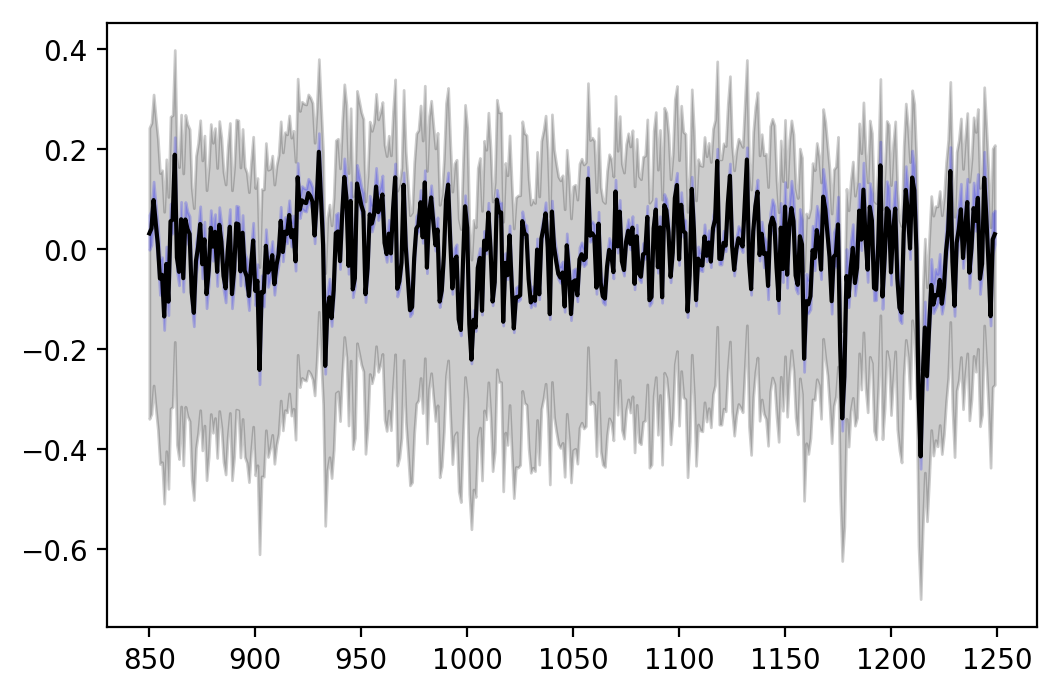

In [65]:
#plt.plot(np.array(recon_years),tas_Gens_allit_1_2d)
plt.plot(np.array(recon_years),np.mean(tas_Gens_allit_1_2d,axis=1),color='k')
#plt.plot(np.array(recon_years),gmt_anom_allit_1,linewidth=1)
plt.fill_between(np.array(recon_years),gmt_recon_2_5_1,gmt_recon_97_5_1,alpha=0.2,color='k')
plt.fill_between(np.array(recon_years),gmt_recon_2_5_anom_1,gmt_recon_97_5_anom_1,alpha=0.2,color='b')

In [66]:
yr = 850
[ce_tot_1,corr_tot_1,_,_] = rrutils.find_ce_corr(np.mean(gmt_anom_allit_1,axis=1),
                                             gmt_ccsm4_anom, 
                                             ccsm4_truth_time[it_truth],
                                             np.array(recon_years),
                                             yr,1249)

print('CE (850-1250) = '+str(ce_tot_1))
print('R^2 (850-1250) = '+str(corr_tot_1**2))

CE (850-1250) = 0.5748066770236392
R^2 (850-1250) = 0.5892060599196225


In [67]:
sie_Nens_allit_10_2d = np.reshape(sie_Nens_allit_10,
                                 (sie_Nens_allit_10.shape[0],
                                  sie_Nens_allit_10.shape[1]*sie_Nens_allit_10.shape[2]))

sie_ens_anom_allit_10 = sie_Nens_allit_10_2d - np.nanmean(sie_Nens_allit_10_2d,axis=0)
sie_ccsm4_recon_anom_10 = np.mean(sie_ens_anom_allit_10,axis=1)

sie_recon_97_5_anom_10 = np.percentile(sie_ens_anom_allit_10,97.5,axis=1)
sie_recon_2_5_anom_10 = np.percentile(sie_ens_anom_allit_10,2.5,axis=1)

tas_Gens_allit_10_2d = np.reshape(tas_Gens_allit_10, 
                               (tas_Gens_allit_10.shape[0],
                               tas_Gens_allit_10.shape[1]*tas_Gens_allit_10.shape[2]))
tas_Nens_allit_10_2d = np.reshape(tas_Nens_allit_10, 
                               (tas_Nens_allit_10.shape[0],
                               tas_Nens_allit_10.shape[1]*tas_Nens_allit_10.shape[2]))

gmt_anom_allit_10 = tas_Gens_allit_10_2d - np.nanmean(tas_Gens_allit_10_2d,axis=0)
nht_anom_allit_10 = tas_Nens_allit_10_2d - np.nanmean(tas_Nens_allit_10_2d,axis=0)

gmt_recon_97_5_anom_10 = np.percentile(gmt_anom_allit_10,97.5,axis=1)
gmt_recon_2_5_anom_10 = np.percentile(gmt_anom_allit_10,2.5,axis=1)

gmt_recon_97_5_10 = np.percentile(tas_Gens_allit_10_2d,97.5,axis=1)
gmt_recon_2_5_10 = np.percentile(tas_Gens_allit_10_2d,2.5,axis=1)

In [68]:
yr = 850
[ce_tot_10,corr_tot_10,_,_] = rrutils.find_ce_corr(np.mean(gmt_anom_allit_10,axis=1),
                                             gmt_ccsm4_anom, 
                                             ccsm4_truth_time[it_truth],
                                             np.array(recon_years),
                                             yr,1249)

print('CE (850-1250) = '+str(ce_tot_10))
print('R^2 (850-1250) = '+str(corr_tot_10**2))

CE (850-1250) = 0.4692479629479106
R^2 (850-1250) = 0.4890380752594875


Text(0,0.5,'Temperature (K)')

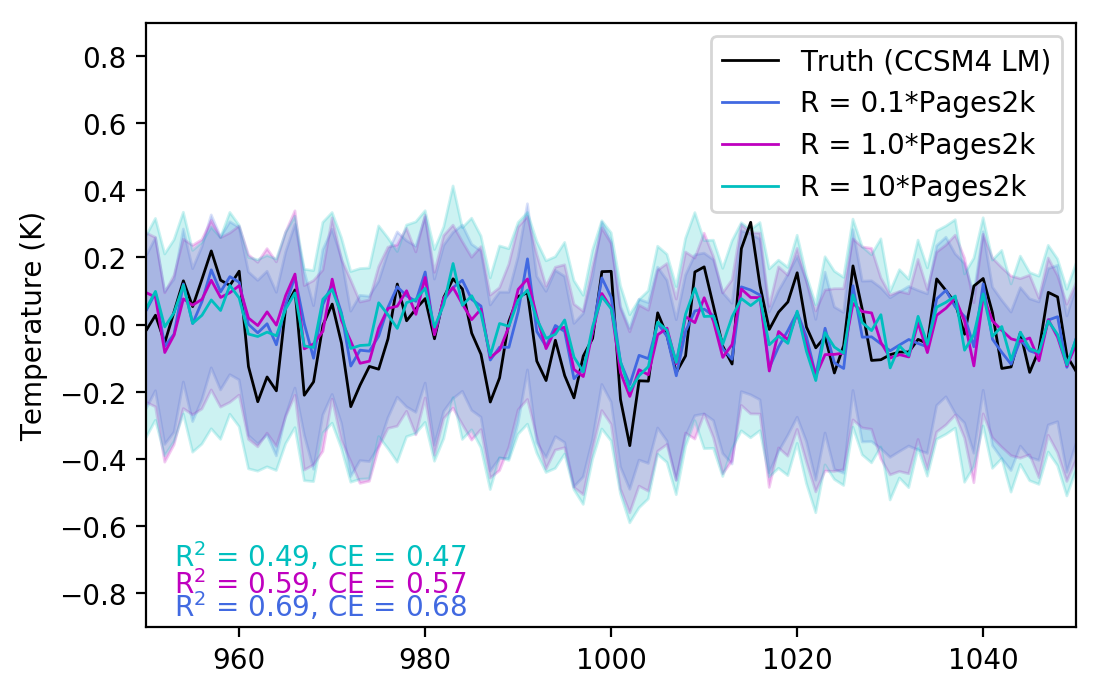

In [71]:
xstart = 950
xend = 1050

plt.plot(ccsm4_truth_time[0:400],gmt_ccsm4_anom,
         linewidth=1,color='k',label='Truth (CCSM4 LM)')

plt.plot(np.array(recon_years),np.mean(gmt_anom_allit,axis=1),
         linewidth=1,color='royalblue',label='R = 0.1*Pages2k')
plt.fill_between(np.array(recon_years),gmt_recon_2_5,gmt_recon_97_5, 
                 alpha=0.2,color='royalblue')

plt.plot(np.array(recon_years_1),np.mean(gmt_anom_allit_1,axis=1),
         linewidth=1,color='m',label='R = 1.0*Pages2k')
plt.fill_between(np.array(recon_years_1),gmt_recon_2_5_1,gmt_recon_97_5_1, 
                 alpha=0.2,color='m')

plt.plot(np.array(recon_years_10),np.mean(gmt_anom_allit_10,axis=1),
         linewidth=1,color='c',label='R = 10*Pages2k')
plt.fill_between(np.array(recon_years_10),gmt_recon_2_5_10,gmt_recon_97_5_10, 
                 alpha=0.2,color='c')

plt.text(xstart+3,-0.72,('R$^2$ = '+str(np.round(corr_tot_10**2,2))+', CE = '+str(np.round(ce_tot_10,2))),
         color='c')
plt.text(xstart+3,-0.8,('R$^2$ = '+str(np.round(corr_tot_1**2,2))+', CE = '+str(np.round(ce_tot_1,2))),
         color='m')
plt.text(xstart+3,-0.87,('R$^2$ = '+str(np.round(corr_tot**2,2))+', CE = '+str(np.round(ce_tot,2))),
         color='royalblue')

plt.legend()
plt.xlim(xstart,xend)
plt.ylim(-0.9,0.9)
plt.ylabel('Temperature (K)')

Text(0,0.5,'Temperature (K)')

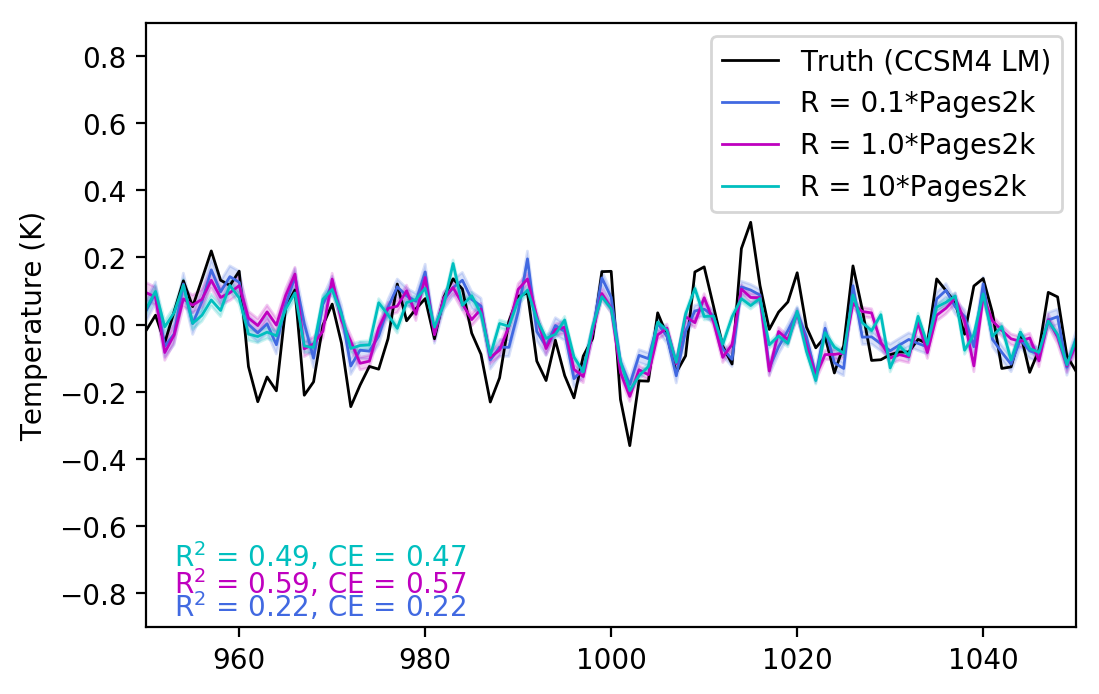

In [49]:
xstart = 950
xend = 1050

plt.plot(ccsm4_truth_time[0:400],gmt_ccsm4_anom,
         linewidth=1,color='k',label='Truth (CCSM4 LM)')

plt.plot(np.array(recon_years),np.mean(gmt_anom_allit,axis=1),
         linewidth=1,color='royalblue',label='R = 0.1*Pages2k')
# plt.fill_between(np.array(recon_years),gmt_recon_2_5,gmt_recon_97_5, 
#                  alpha=0.2,color='royalblue')
plt.fill_between(np.array(recon_years),gmt_recon_2_5_anom,gmt_recon_97_5_anom, 
                 alpha=0.2,color='royalblue')

plt.plot(np.array(recon_years_1),np.mean(gmt_anom_allit_1,axis=1),
         linewidth=1,color='m',label='R = 1.0*Pages2k')
# plt.fill_between(np.array(recon_years_1),gmt_recon_2_5_1,gmt_recon_97_5_1, 
#                  alpha=0.2,color='m')
plt.fill_between(np.array(recon_years_1),gmt_recon_2_5_anom_1,gmt_recon_97_5_anom_1, 
                 alpha=0.2,color='m')

plt.plot(np.array(recon_years_10),np.mean(gmt_anom_allit_10,axis=1),
         linewidth=1,color='c',label='R = 10*Pages2k')
# plt.fill_between(np.array(recon_years_10),gmt_recon_2_5_10,gmt_recon_97_5_10, 
#                  alpha=0.2,color='c')
plt.fill_between(np.array(recon_years_10),gmt_recon_2_5_anom_10,gmt_recon_97_5_anom_10, 
                 alpha=0.2,color='c')

plt.text(xstart+3,-0.72,('R$^2$ = '+str(np.round(corr_tot_10**2,2))+', CE = '+str(np.round(ce_tot_10,2))),
         color='c')
plt.text(xstart+3,-0.8,('R$^2$ = '+str(np.round(corr_tot_1**2,2))+', CE = '+str(np.round(ce_tot_1,2))),
         color='m')
plt.text(xstart+3,-0.87,('R$^2$ = '+str(np.round(corr_tot**2,2))+', CE = '+str(np.round(ce_tot,2))),
         color='royalblue')

plt.legend()
plt.xlim(xstart,xend)
plt.ylim(-0.9,0.9)
plt.ylabel('Temperature (K)')

In [82]:
ind = (ccsm4_truth_time>=recon_start)&(ccsm4_truth_time<=recon_end)

gmt_ccsm4_anom_full = gmt_ccsm4 - np.mean(gmt_ccsm4[ind])

In [110]:
sie_Nens_allit_a_2d = np.reshape(sie_Nens_allit_a,
                                 (sie_Nens_allit_a.shape[0],
                                  sie_Nens_allit_a.shape[1]*sie_Nens_allit_a.shape[2]))

sie_ens_anom_allit_a = sie_Nens_allit_a_2d - np.nanmean(sie_Nens_allit_a_2d,axis=0)
sie_ccsm4_recon_anom_a = np.mean(sie_ens_anom_allit_a,axis=1)

sie_recon_97_5_anom_a = np.percentile(sie_ens_anom_allit_a,97.5,axis=1)
sie_recon_2_5_anom_a = np.percentile(sie_ens_anom_allit_a,2.5,axis=1)

tas_Gens_allit_a_2d = np.reshape(tas_Gens_allit_a, 
                               (tas_Gens_allit_a.shape[0],
                               tas_Gens_allit_a.shape[1]*tas_Gens_allit_a.shape[2]))
tas_Nens_allit_a_2d = np.reshape(tas_Nens_allit_a, 
                               (tas_Nens_allit_a.shape[0],
                               tas_Nens_allit_a.shape[1]*tas_Nens_allit_a.shape[2]))

gmt_anom_allit_a = tas_Gens_allit_a_2d - np.nanmean(tas_Gens_allit_a_2d,axis=0)
nht_anom_allit_a = tas_Nens_allit_a_2d - np.nanmean(tas_Nens_allit_a_2d,axis=0)

gmt_recon_97_5_anom_a = np.percentile(gmt_anom_allit_a,97.5,axis=1)
gmt_recon_2_5_anom_a = np.percentile(gmt_anom_allit_a, 2.5,axis=1)

gmt_recon_97_5_a = np.percentile(tas_Gens_allit_a_2d,97.5,axis=1)
gmt_recon_2_5_a = np.percentile(tas_Gens_allit_a_2d,2.5,axis=1)

In [112]:
yr = 850
[ce_tot_a,corr_tot_a,_,_] = rrutils.find_ce_corr(np.mean(gmt_anom_allit_a,axis=1),
                                                 gmt_ccsm4_anom, 
                                                 ccsm4_truth_time,
                                                 np.array(recon_years_a),
                                                 yr,1849)

print('CE (850-1250) = '+str(ce_tot_a))
print('R^2 (850-1250) = '+str(corr_tot_a**2))

CE (850-1250) = 0.7777922646380986
R^2 (850-1250) = 0.8655181815777298


In [131]:
yr = 850
[ce_tot_si_a,corr_tot_si_a,_,_] = rrutils.find_ce_corr(np.mean(sie_ens_anom_allit_a,axis=1),
                                                     sie_nh_ccsm4_truth_anom, 
                                                     ccsm4_truth_time,
                                                     np.array(recon_years_a),
                                                     yr,1849)

print('CE (850-1250) = '+str(ce_tot_si_a))
print('R^2 (850-1250) = '+str(corr_tot_si_a**2))

CE (850-1250) = 0.2824696869790112
R^2 (850-1250) = 0.4508010153303926


In [113]:
sie_Nens_allit_b_2d = np.reshape(sie_Nens_allit_b,
                                 (sie_Nens_allit_b.shape[0],
                                  sie_Nens_allit_b.shape[1]*sie_Nens_allit_b.shape[2]))

sie_ens_anom_allit_b = sie_Nens_allit_b_2d - np.nanmean(sie_Nens_allit_b_2d,axis=0)
sie_ccsm4_recon_anom_b = np.mean(sie_ens_anom_allit_b,axis=1)

sie_recon_97_5_anom_b = np.percentile(sie_ens_anom_allit_b,97.5,axis=1)
sie_recon_2_5_anom_b = np.percentile(sie_ens_anom_allit_b,2.5,axis=1)

tas_Gens_allit_b_2d = np.reshape(tas_Gens_allit_b, 
                               (tas_Gens_allit_b.shape[0],
                               tas_Gens_allit_b.shape[1]*tas_Gens_allit_b.shape[2]))
tas_Nens_allit_b_2d = np.reshape(tas_Nens_allit_b, 
                               (tas_Nens_allit_b.shape[0],
                               tas_Nens_allit_b.shape[1]*tas_Nens_allit_b.shape[2]))

gmt_anom_allit_b = tas_Gens_allit_b_2d - np.nanmean(tas_Gens_allit_b_2d,axis=0)
nht_anom_allit_b = tas_Nens_allit_b_2d - np.nanmean(tas_Nens_allit_b_2d,axis=0)

gmt_recon_97_5_anom_b = np.percentile(gmt_anom_allit_b,97.5,axis=1)
gmt_recon_2_5_anom_b = np.percentile(gmt_anom_allit_b, 2.5,axis=1)

gmt_recon_97_5_b = np.percentile(tas_Gens_allit_b_2d,97.5,axis=1)
gmt_recon_2_5_b = np.percentile(tas_Gens_allit_b_2d,2.5,axis=1)

In [114]:
yr = 850
[ce_tot_b,corr_tot_b,_,_] = rrutils.find_ce_corr(np.mean(gmt_anom_allit_b,axis=1),
                                                 gmt_ccsm4_anom, 
                                                 ccsm4_truth_time,
                                                 np.array(recon_years_b),
                                                 yr,1849)

print('CE (850-1250) = '+str(ce_tot_b))
print('R^2 (850-1250) = '+str(corr_tot_b**2))

CE (850-1250) = 0.7746473622636846
R^2 (850-1250) = 0.8570485183729402


In [132]:
yr = 850
[ce_tot_si_b,corr_tot_si_b,_,_] = rrutils.find_ce_corr(np.mean(sie_ens_anom_allit_b,axis=1),
                                                     sie_nh_ccsm4_truth_anom, 
                                                     ccsm4_truth_time,
                                                     np.array(recon_years_b),
                                                     yr,1849)

print('CE (850-1250) = '+str(ce_tot_si_b))
print('R^2 (850-1250) = '+str(corr_tot_si_b**2))

CE (850-1250) = 0.4447368384718857
R^2 (850-1250) = 0.45033698461844623


In [124]:
sie_ens_anom_allit_a.shape

(1000, 200)

Text(0,0.5,'Temperature (K)')

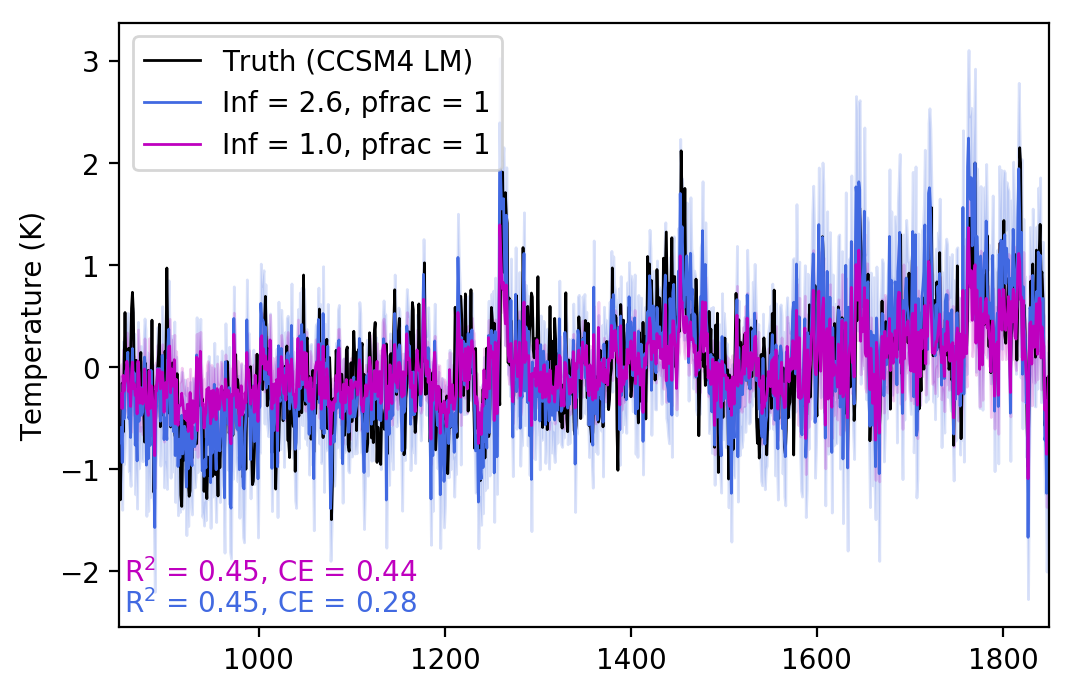

In [141]:
xstart = 850
xend = 1850

plt.plot(ccsm4_truth_time[:-1],sie_nh_ccsm4_truth_anom,
         linewidth=1,color='k',label='Truth (CCSM4 LM)')

plt.plot(np.array(recon_years_a),np.mean(sie_ens_anom_allit_a,axis=1),
         linewidth=1,color='royalblue',label='Inf = 2.6, pfrac = 1')
# plt.fill_between(np.array(recon_years),gmt_recon_2_5,gmt_recon_97_5, 
#                  alpha=0.2,color='royalblue')
plt.fill_between(np.array(recon_years_a),sie_recon_2_5_anom_a,sie_recon_97_5_anom_a, 
                 alpha=0.2,color='royalblue')

plt.plot(np.array(recon_years_b),np.mean(sie_ens_anom_allit_b,axis=1),
         linewidth=1,color='m',label='Inf = 1.0, pfrac = 1')
# plt.fill_between(np.array(recon_years_1),gmt_recon_2_5_1,gmt_recon_97_5_1, 
#                  alpha=0.2,color='m')
plt.fill_between(np.array(recon_years_b),sie_recon_2_5_anom_b,sie_recon_97_5_anom_b, 
                 alpha=0.2,color='m')


plt.text(xstart+5,-2.1,('R$^2$ = '+str(np.round(corr_tot_si_b**2,2))+', CE = '+str(np.round(ce_tot_si_b,2))),
         color='m')
plt.text(xstart+5,-2.4,('R$^2$ = '+str(np.round(corr_tot_si_a**2,2))+', CE = '+str(np.round(ce_tot_si_a,2))),
         color='royalblue')

plt.legend()
plt.xlim(xstart,xend)
#plt.ylim(-0.9,0.9)
#plt.xlim(850,1050)
plt.ylabel('Temperature (K)')

In [29]:
np.mean(gmt_ccsm4_anom), np.mean(np.mean(gmt_anom_allit,axis=1),axis=0)

(0.000272945729277051, 2.220446049250313e-18)

In [30]:
('sic_sit_'+prior_name+'_anrecon_'+str(recon_start)+'_'+
                     str(recon_end)+'_'+proxies+'_inf'+inf_name+'_loc'+str(loc_list[0])+
                    '_R'+obfac+serr+'_iter'+str(iter_num)+'.pkl')

NameError: name 'prior_name' is not defined

In [31]:
yr = 850
[ce_tot,corr_tot,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                             sie_nh_ccsm4_truth_anom, 
                                             ccsm4_truth_time[it_truth],
                                             np.array(recon_years),
                                             yr,1849)

print('CE (850-1850) = '+str(ce_tot))
print('R^2 (850-1850) = '+str(corr_tot**2))

CE (850-1850) = 0.22293357688904303
R^2 (850-1850) = 0.22491715412177293


In [32]:
# plt.plot(sie_ccsm4_recon_anom)
# plt.plot(sie_nh_ccsm4_truth_anom)

In [34]:
seg_length =500
ce_sie_pseudo = []
corr_sie_pseudo = []

for yr in range(recon_years[0],recon_years[-1]-seg_length+1): 
#    print(str(yr))
    [ce_seg,
     corr_seg,_,_] = rrutils.find_ce_corr(sie_ccsm4_recon_anom,
                                          sie_nh_ccsm4_truth_anom, 
                                          ccsm4_truth_time[it_truth],
                                          np.array(recon_years),
                                          yr,yr+seg_length)

    ce_sie_pseudo = np.append(ce_sie_pseudo,ce_seg)
    corr_sie_pseudo = np.append(corr_sie_pseudo,corr_seg)

In [35]:
corr_sie_pseudo[0]**2

0.31311894011398217

Text(0.5,1,'Skill in time: 500 year segments')

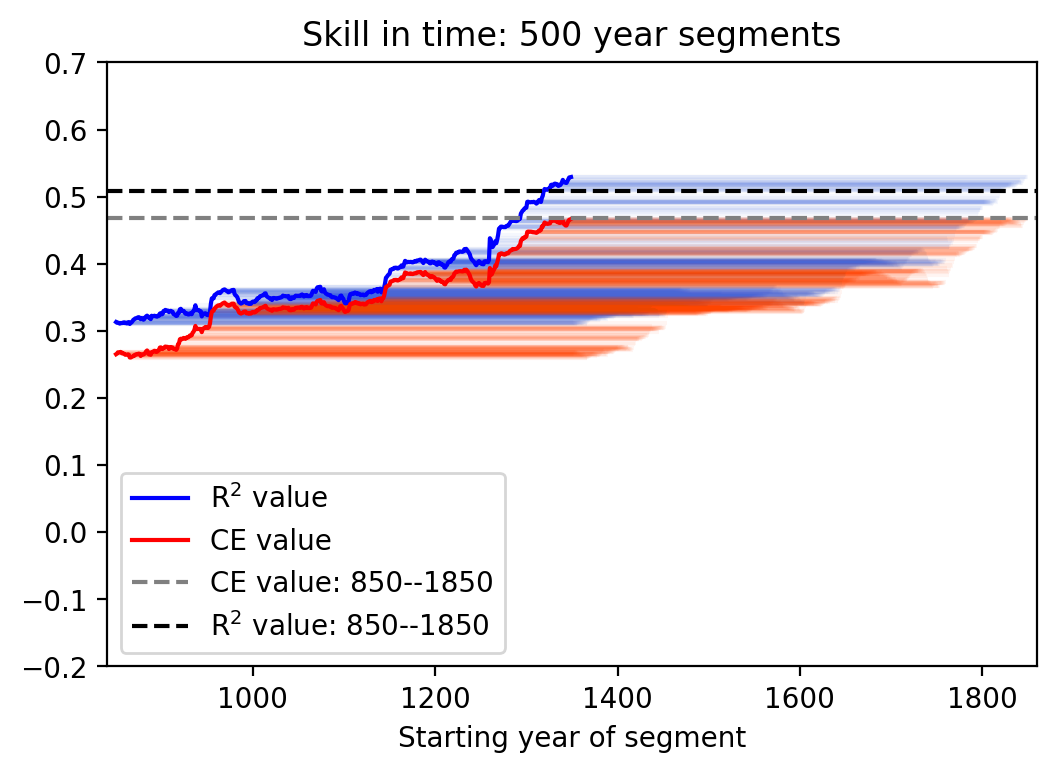

In [36]:
for i in range(corr_sie_pseudo.shape[0]): 
    plt.hlines(corr_sie_pseudo[i]**2,recon_years[i],recon_years[i]+seg_length+1,color='royalblue',alpha=0.05)
    plt.hlines(ce_sie_pseudo[i],recon_years[i],recon_years[i]+seg_length+1,color='orangered',alpha=0.05)

plt.plot(range(recon_years[0],recon_years[-1]-seg_length+1),corr_sie_pseudo**2, 
         label='R$^2$ value',color='blue')
plt.plot(range(recon_years[0],recon_years[-1]-seg_length+1),ce_sie_pseudo, 
         label='CE value',color='red')        
        
plt.axhline(ce_tot,linestyle='--',color='gray',label='CE value: 850--1850')
plt.axhline(corr_tot**2,linestyle='--',color='k',label='R$^2$ value: 850--1850')
#plt.axhline(ce_tot,linestyle='--',color='orangered',label='CE value: 850--1850')

plt.xlim(840,1860)
plt.ylim(-0.2,0.7)
plt.xlabel('Starting year of segment')
plt.legend(fontsize=10)
plt.title('Skill in time: '+str(seg_length)+' year segments')

In [46]:
MSE = np.mean(((sie_nh_ccsm4_truth_anom[:-1,np.newaxis] - sie_ens_anom_allit)**2),axis=1)
SE = 

(1000,)

In [39]:
Wn2 = 1.0/30
nf2 = 7
b2,a2 = signal.butter(nf2,Wn2,btype='lowpass')
w2, h2 = signal.freqs(b2, a2)
MSE_filt20 = signal.filtfilt(b2,a2,MSE)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Text(0.5,1,'Perfect Model Experiment')

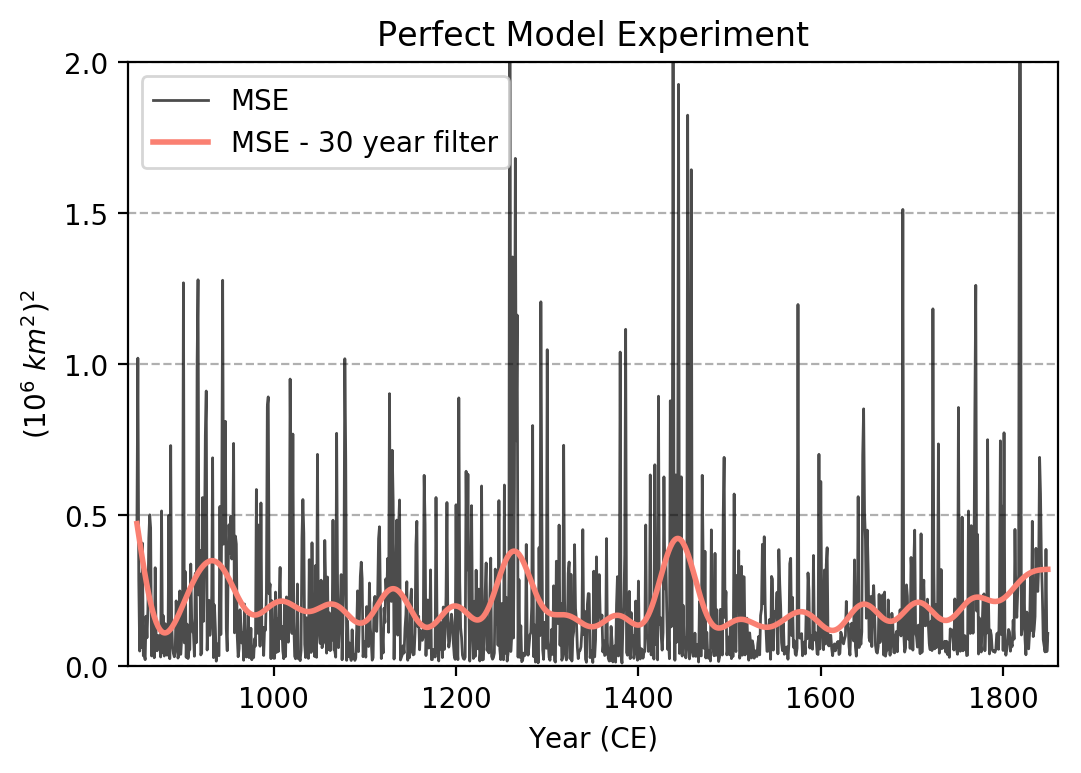

In [51]:
plt.plot(recon_years,MSE,label='MSE',color='k',linewidth=1, alpha=0.7)    
plt.plot(recon_years,MSE_filt20,label='MSE - 30 year filter',color='salmon', linewidth=2)    

plt.grid(linestyle='--', axis='y', which='major')
plt.yticks(np.arange(0,2.1,0.5))

plt.xlim(840,1860)
plt.ylim(0,2)
plt.xlabel('Year (CE)')
plt.ylabel('(10$^{6}$ $km^2$)$^2$')
plt.legend(fontsize=10)
plt.title('Perfect Model Experiment',fontsize=12)

In [41]:
print('Stdev(truth)= '+str(np.std(sie_nh_ccsm4_truth_anom)))
print('Stdev(recon)= '+str(np.std(sie_ccsm4_recon_anom)))

Stdev(truth)= 0.5703990018495324
Stdev(recon)= 0.2935624889104526


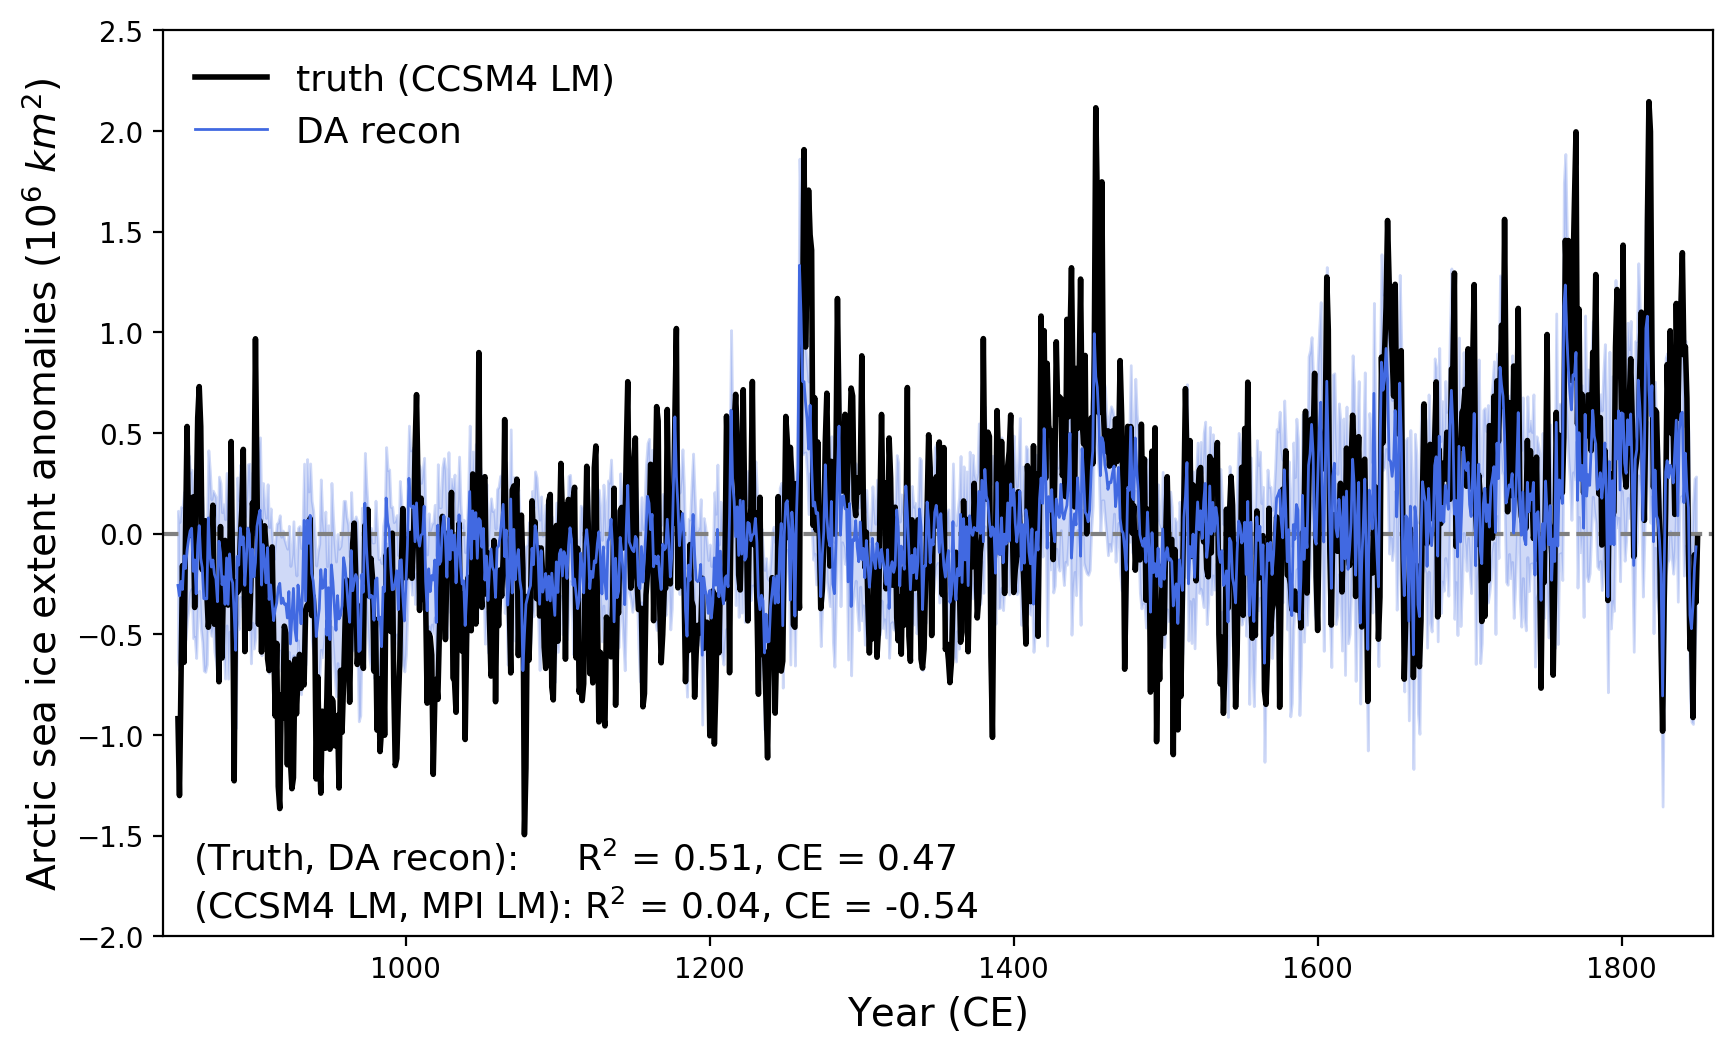

In [77]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

# plt.plot(mpi_time[it_mpi],sie_nh_mpi_anom, label='MPI LM',
#          color='gray',linewidth=1, linestyle ='--')
plt.plot(ccsm4_truth_time[it_truth],sie_nh_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2)
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Arctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_tot**2))+
                     ', CE = '+'{:,.2f}'.format(ce_tot))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
                      '{:,.2f}'.format(corr_sie_mod**2))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(840,1860)
plt.ylim(-2,2.5)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sie_timeseries_performance_recon_850_1850_truth.png'
#plt.savefig(savedir+savename)

In [121]:
corr_tot

0.7129484543785247

Text(0,0.5,'Number of proxies assimilated')

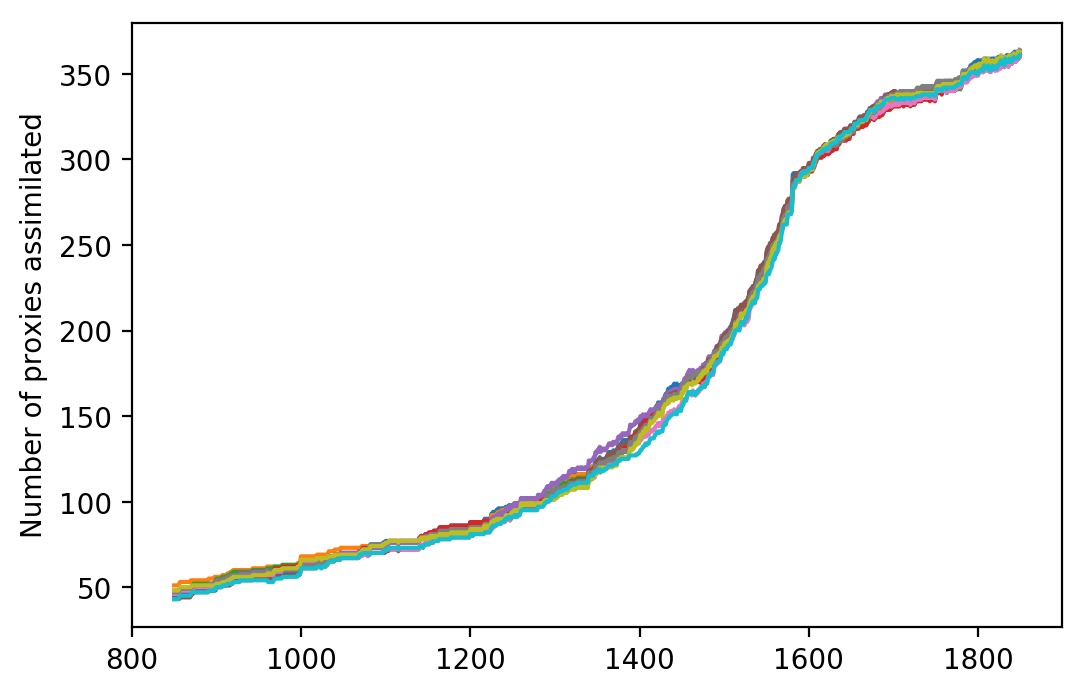

In [122]:
plt.plot(recon_years, nobs_allit)
plt.ylabel('Number of proxies assimilated')

## Southern Hemisphere skill: 

In [96]:
sie_Sens_allit_2d = np.reshape(sie_Sens_allit,
                               (sie_Sens_allit.shape[0],
                                sie_Sens_allit.shape[1]*sie_Sens_allit.shape[2]))
sie_Sens_allit_anom = sie_Sens_allit_2d - np.nanmean(sie_Sens_allit_2d,axis=0)
sie_ccsm4_recon_anom = np.nanmean(sie_Sens_allit_anom,axis=1)

sie_recon_97_5_anom = np.percentile(sie_Sens_allit_anom,97.5,axis=1)
sie_recon_2_5_anom = np.percentile(sie_Sens_allit_anom,2.5,axis=1)

In [97]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_sh_ccsm4_truth_anom, 
                                          sie_sh_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_truth],
                                          recon_start, recon_end)

corr_sie_mod**2,ce_sie_mod

(0.003908471880339358, -0.16630637393761893)

In [98]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_sh_ccsm4_truth_anom, 
                                             sie_ccsm4_recon_anom,
                                             np.array(recon_years),
                                             ccsm4_truth_time[it_truth],
                                             recon_start,recon_end)

corr_sie_pseudo,ce_sie_pseudo

(0.4113542194311646, -37.58888800710331)

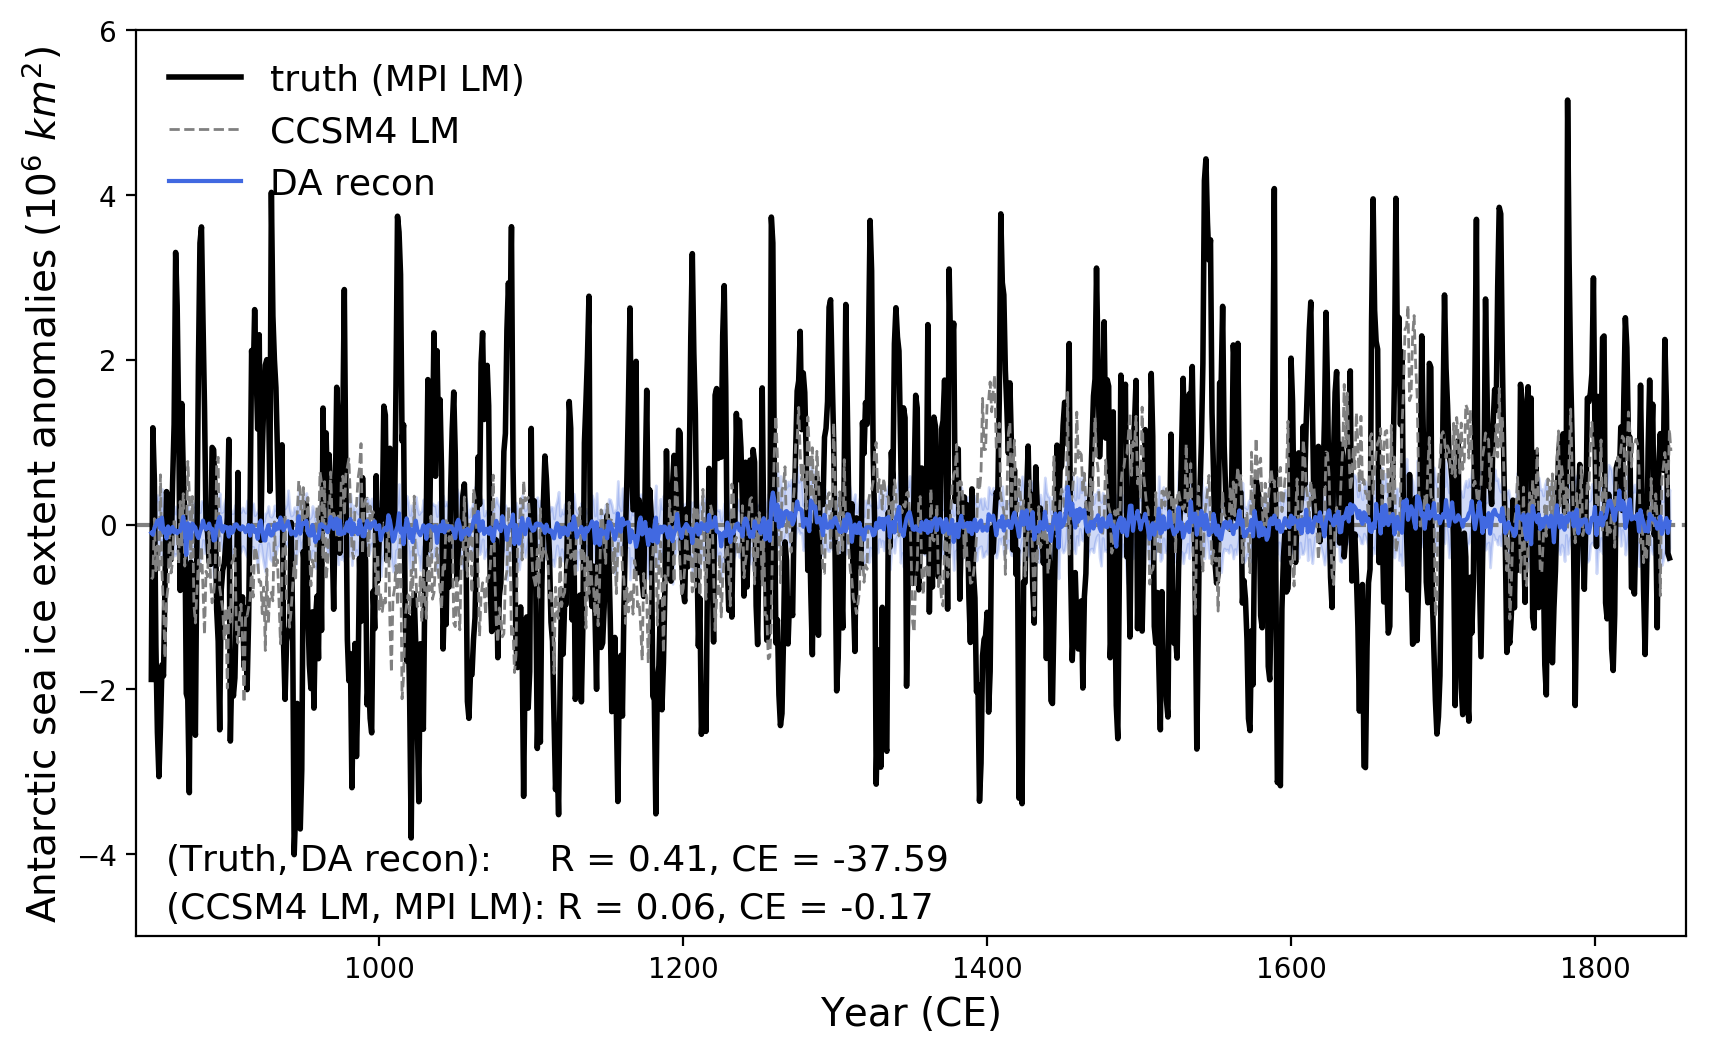

In [99]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_sh_mpi_anom, label='truth (MPI LM)',
         color='k',linewidth=2)
plt.plot(ccsm4_truth_time[it_truth],sie_sh_ccsm4_truth_anom, label='CCSM4 LM',
         color='gray',linewidth=1, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Antarctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-5,6,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R = ' + 
                      '{:,.2f}'.format(corr_sie_mod))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(840,1860)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_antarctic_sie_timeseries_performance_recon_850_1850_truth.png'
#plt.savefig(savedir+savename)

#### Load proxy locations for plotting: 

In [103]:
proxinfo_loc = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/'+
            'experiments/pseudo/pages2kv2_all_proxy_info.pkl')

prox_loc_info = pickle.load(open(proxinfo_loc,'rb'))

In [104]:
proxy_types = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity', 
               'Ice Cores_d18O', 'Ice Cores_dD', 
               'Ice Cores_MeltFeature', 'Lake Cores_Varve',
               'Lake Cores_Misc']

### Spatial validation: SIT

In [105]:
sit_shape = sit_lalo_allit.shape
sit_shape_true = ccsm4_truth_sit.shape
sit_lalo_ensmn = np.nanmean(sit_lalo_allit,axis=3)

sit_recon_2d = np.reshape(sit_lalo_ensmn,(sit_shape[0],sit_shape[1]*sit_shape[2]))
sit_truth_2d = np.reshape(ccsm4_truth_sit,(sit_shape_true[0],sit_shape_true[1]*sit_shape_true[2]))
sit_truth_2d = np.squeeze(sit_truth_2d[it_truth,:])[:-1]

In [106]:
r_sit = np.zeros(sit_truth_2d.shape[1])
r2_sit = np.zeros(sit_truth_2d.shape[1])
ce_sit = np.zeros(sit_truth_2d.shape[1])

for lalo in range(sit_truth_2d.shape[1]):
    r_sit[lalo],r2_sit[lalo],_ = kbstats.corr_timeseries(sit_truth_2d[:,lalo],sit_recon_2d[:,lalo])
    ce_sit[lalo]= kbstats.coefficient_efficiency(sit_truth_2d[:,lalo],sit_recon_2d[:,lalo])

/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


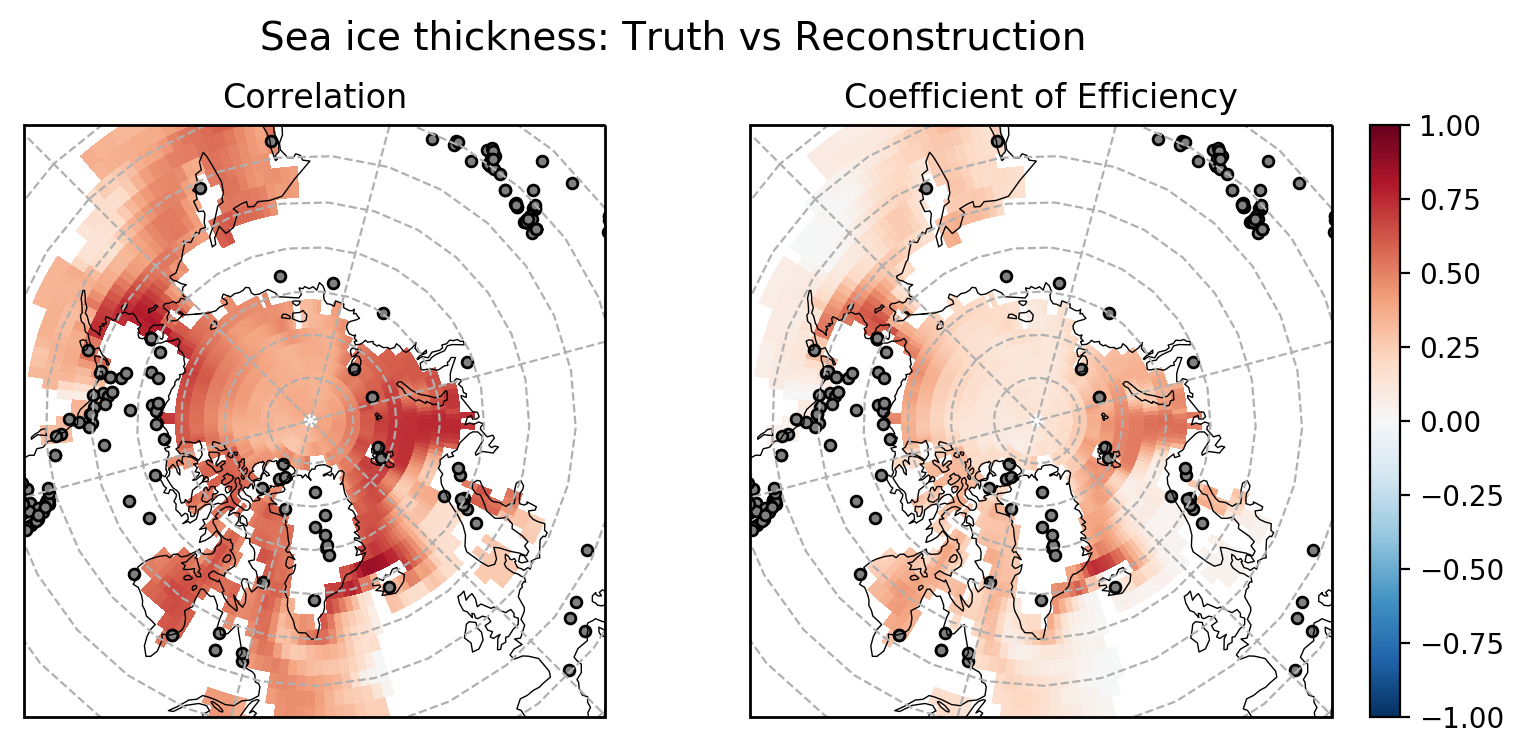

In [107]:
r_sit = np.reshape(r_sit,(sit_shape_true[1],sit_shape_true[2]))
ce_sit = np.reshape(ce_sit,(sit_shape_true[1],sit_shape_true[2]))

fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],r_sit,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax[1],ce_sit,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax[0].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax[1].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Sea ice thickness: Truth vs Reconstruction', fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sit_spatial_performance_recon_850_1850_truth_r_CE.png'
#plt.savefig(savedir+savename)

### Spatial validation: SIC

In [108]:
sic_shape = sic_lalo_allit.shape
sic_shape_true = ccsm4_truth_sic.shape

sic_lalo_ensmn = np.nanmean(sic_lalo_allit,axis=3)
sic_truth_lalo = np.squeeze(ccsm4_truth_sic[it_truth,:,:])[:-1]
sic_2_5_lalo = np.percentile(sic_lalo_allit,2.5,axis=3)
sic_97_5_lalo = np.percentile(sic_lalo_allit,97.5,axis=3)

sic_prior_ensmn = np.reshape(np.nanmean(Xb_inflate_allit[91*180:91*180*2],axis=2).T,(200,91,180))

sic_recon_2d = np.reshape(sic_lalo_ensmn,(sic_shape[0],sic_shape[1]*sic_shape[2]))
sic_truth_2d = np.reshape(ccsm4_truth_sic,(sic_shape_true[0],sic_shape_true[1]*sic_shape_true[2]))
sic_truth_2d = np.squeeze(sic_truth_2d[it_truth,:])[:-1]

In [109]:
ccsm4_truth_sic.shape

(1001, 91, 180)

In [110]:
r_sic = np.zeros(sic_truth_2d.shape[1])
r2_sic = np.zeros(sic_truth_2d.shape[1])
ce_sic = np.zeros(sic_truth_2d.shape[1])

for lalo in range(sic_truth_2d.shape[1]):
    r_sic[lalo],r2_sic[lalo],_ = kbstats.corr_timeseries(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])
    ce_sic[lalo]= kbstats.coefficient_efficiency(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])

/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


In [111]:
# r_thresh = np.where(r_sic>np.sqrt(0.4),1.0,0.0)
# ce_thresh = np.where(ce_sic>np.sqrt(0.4),1.0,0.0)
# ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], r_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())
# ax[1].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], ce_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())

# ax[0].scatter(obs_lon, obs_lat, facecolors='grey', s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())
# ax[1].scatter(obs_lon, obs_lat, facecolors='grey',s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


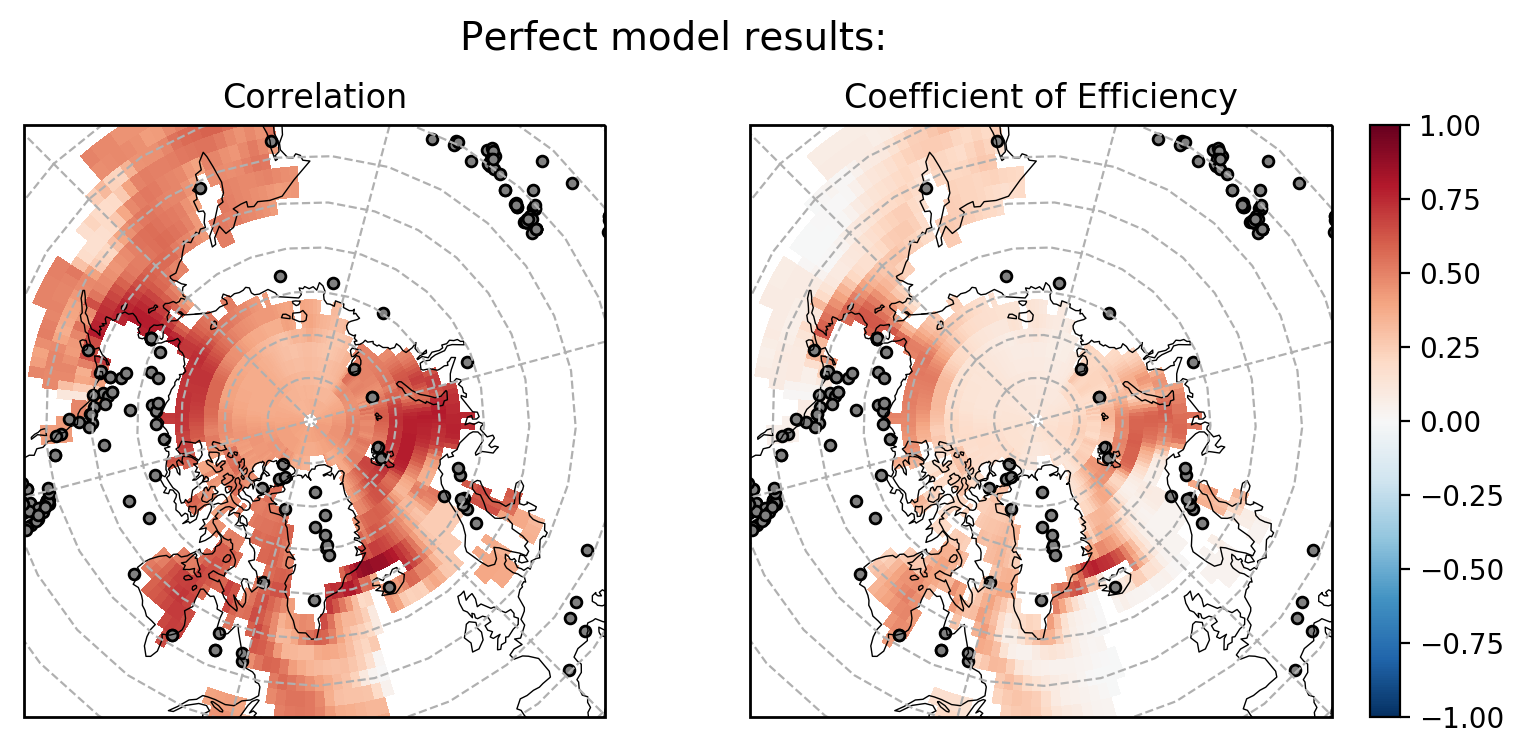

In [112]:
r_sic = np.reshape(r_sic,(sic_shape_true[1],sic_shape_true[2]))
ce_sic = np.reshape(ce_sic,(sic_shape_true[1],sic_shape_true[2]))

fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax[0].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax[1].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Perfect model results:',fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sic_spatial_performance_recon_850_1850_truth_r_CE.png'
#plt.savefig(savedir+savename)

In [49]:
# Index of lat/lon of interest: 

# # Barents blue region:
lat_interest = 79
lon_interest = 3

# # S greenland blue region: 
# lat_interest = 77
# lon_interest = 166

# S Alaska blue region: 
# lat_interest = 73
# lon_interest = 108

# lat_interest = 75
# lon_interest = 75

sic_thresh = np.where(r_sic>np.sqrt(0.5),1.0,0.0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


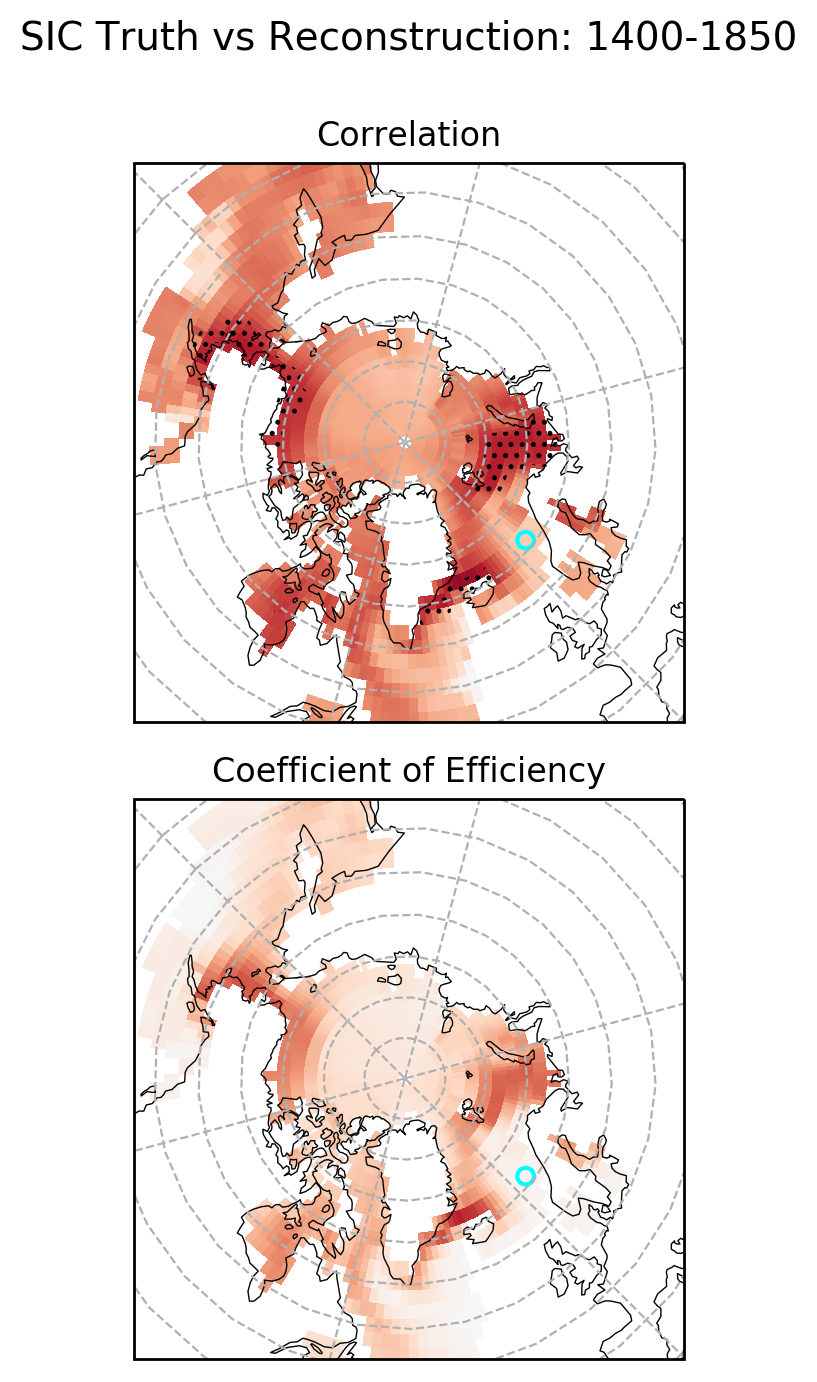

In [50]:
fig,ax = plt.subplots(2,1, figsize=(4, 7), subplot_kw = proj)
sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)
fig.suptitle('SIC Truth vs Reconstruction: 1400-1850', fontsize=14)
plt.tight_layout(rect=(0,0,1,0.93))
ax[0].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)
ax[1].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)

ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], sic_thresh, 
                  levels = [0,0.5,1],hatches=['','...'], alpha=0,
                  transform=ccrs.PlateCarree())
#plt.scatter(100, 10, color='m')

# savename = 'arctic_sic_gridcell_location_lat_'+str(lat_interest)+'_lon_'+str(lon_interest)+'.png'
# plt.savefig(savepath+savename)

In [51]:
r_pt,_,_ = kbstats.corr_timeseries(sic_truth_lalo[:,lat_interest,lon_interest],
                                   sic_lalo_ensmn[:,lat_interest,lon_interest])
ce_pt = kbstats.coefficient_efficiency(sic_truth_lalo[:,lat_interest,lon_interest],
                                       sic_lalo_ensmn[:,lat_interest,lon_interest])

In [52]:
print('Truth variance = ',str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2)))
print('Recon variance = ',str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2)))

Truth variance =  0.0
Recon variance =  0.0


In [53]:
min = sic_truth_lalo[:,lat_interest,lon_interest].min()
max = sic_truth_lalo[:,lat_interest,lon_interest].max()

In [54]:
np.var(sic_truth_lalo[:,lat_interest,lon_interest])

0.000982812335688267

In [55]:
print('CE = '+str(np.round(ce_pt,2))) 
print('Corr = '+str(np.round(r_pt,2)))
print('Var(truth) = '+str(np.var(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Var(recon) = '+str(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest])))
print('Mean(truth) = '+str(np.mean(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Mean(recon) = '+str(np.mean(sic_lalo_ensmn[:,lat_interest,lon_interest])))

CE = 0.03
Corr = 0.25
Var(truth) = 0.000982812335688267
Var(recon) = 4.547428741612511e-06
Mean(truth) = 0.0011194815351756823
Mean(recon) = 0.0027924893467135177


(-0.005, 0.021)

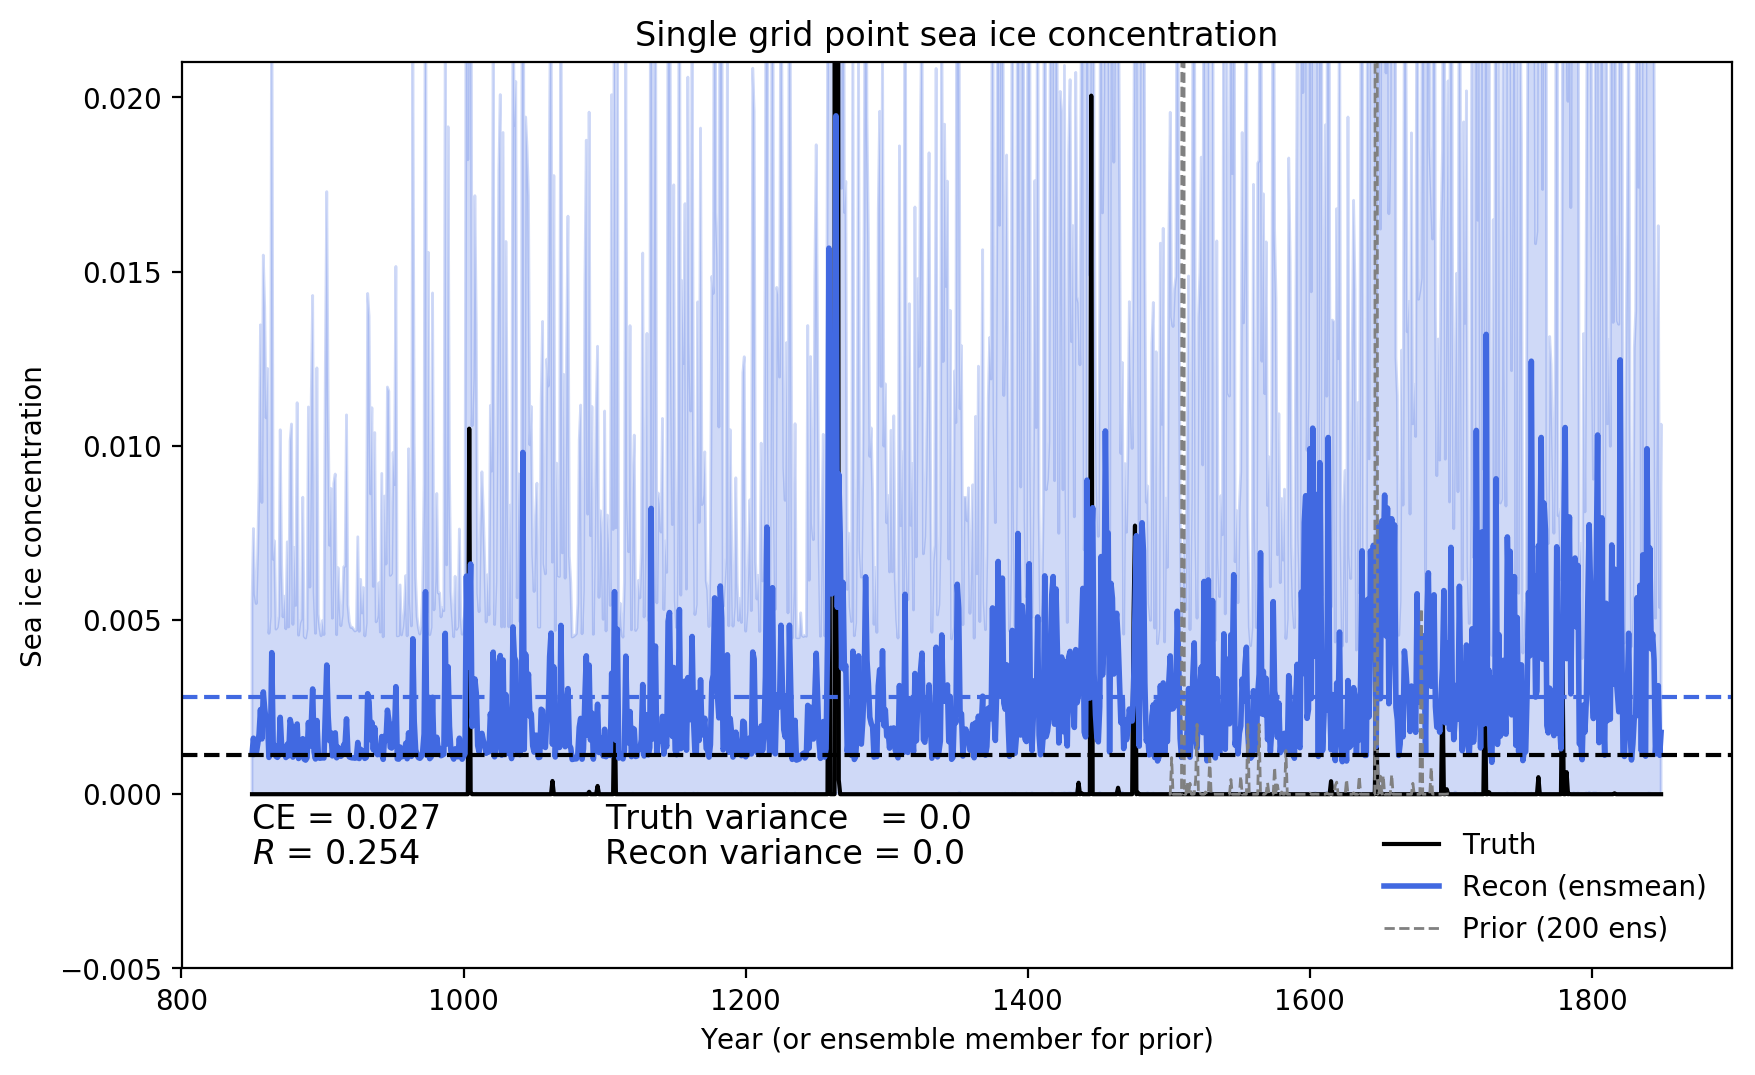

In [56]:
fig = plt.figure(figsize=(10,6))
plt.plot(recon_years, sic_truth_lalo[:,lat_interest,lon_interest], 
         color='k', label='Truth', linewidth=1.5)
plt.plot(recon_years, sic_lalo_ensmn[:,lat_interest,lon_interest], 
         color='royalblue', label='Recon (ensmean)', linewidth=2)
plt.fill_between(recon_years,sic_2_5_lalo[:,lat_interest,lon_interest],
                 sic_97_5_lalo[:,lat_interest,lon_interest],color='royalblue',alpha=0.25)
plt.plot(range(1500,1700),sic_prior_ensmn[:,lat_interest,lon_interest], 
         color='grey', label='Prior (200 ens)', linewidth=1, linestyle='--')

plt.axhline(np.nanmean(sic_truth_lalo[:,lat_interest,lon_interest],axis=0),
            color='k',linestyle='--')
plt.axhline(np.nanmean(sic_lalo_ensmn[:,lat_interest,lon_interest],axis=0),
            color='royalblue',linestyle='--')

text_locl = np.round(sic_lalo_ensmn[:,lat_interest,lon_interest].min(),2)
text_loch = np.round(sic_lalo_ensmn[:,lat_interest,lon_interest].max(),2)
text_diff = ((text_loch-text_locl)/10)*0.5

plt.text(850,text_locl-2*text_diff,('$R$ = '+str(np.round(r_pt,3))),fontsize=12)
plt.text(850,text_locl-text_diff,('CE = '+str(np.round(ce_pt,3))),fontsize=12)

plt.text(1100,text_locl-2*text_diff,('Recon variance = '+str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2))),fontsize=12)
plt.text(1100,text_locl-text_diff,('Truth variance   = '+str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2))),fontsize=12)

plt.legend(loc='lower right',frameon=False)
plt.ylabel('Sea ice concentration')
plt.xlabel('Year (or ensemble member for prior)')
plt.title('Single grid point sea ice concentration')

plt.ylim(text_locl-5*text_diff,text_loch+text_diff)
#plt.ylim(-0.01,0.05)
#plt.xlim(1400,1601)
#plt.ylim(88,101)

In [ ]:
sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_lite_utils as LMRlite
import LMR_config

In [ ]:
cfile = '/home/disk/kalman2/mkb22/LMR_lite/configs/config_ccsm4_sit_brennan2020.yml'

proxies = 'pseudo'

savedir = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/')

print('loading configuration...')
cfg = LMRlite.load_config_simple(cfile)